# Market Gap Analysis: Sugar Trap

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np
import re
from collections import Counter

### Task 1 
Data Cleaning

In [3]:
# Bring the function to properly clean the data

def wrangle(filepath):
  df = pd.read_csv(filepath, sep="\t", low_memory=False)
  
  # Select the snacks 
  snacks = df[df["categories_tags"].str.contains("Snack", case=False, na=False)].copy()
  
  #drop the columns with > 20% missing
  max_drop = int(len(snacks) * 0.20)
  snacks.drop(columns=snacks.columns[snacks.isna().sum() > max_drop], inplace=True)
  
  # drop code, url & time columns
  snacks.drop(columns=[
    "code", "url", "created_t", "created_datetime", "last_modified_t", 
    "last_modified_datetime", "last_modified_by", "last_updated_t", "last_updated_datetime"
], inplace=True)
  
  # drop duplicate country & categorie columns
  snacks.drop(columns=["categories", "categories_tags", "countries", "countries_tags", "main_category", "states", "states_tags"], inplace=True)
  
  # drop the ingredients and serving columns
  snacks.drop(columns=[ "ingredients_tags", "ingredients_analysis_tags", "serving_size", "serving_quantity"], inplace=True)


  # Replace missing product & country names with "Unknown"
  snacks["product_name"]=snacks["product_name"].fillna("Unknown")
  snacks["countries_en"]=snacks["countries_en"].fillna("Unknown")

  # Replace nutriscore_grade's missing vale with unknown
  snacks["nutriscore_grade"]=snacks["nutriscore_grade"].fillna("unknown")

  # replace missing nova_group(food_processed) with the most common value (mode)
  snacks["nova_group"]=snacks["nova_group"].fillna(snacks["nova_group"].mode()[0])

  # reomve rows with energy_kcal_100g > 900  
  snacks = snacks[snacks["energy-kcal_100g"] <= 900]

  # reomve rows with energy_100g > 4000
  snacks = snacks[snacks["energy_100g"] <= 4000]

  # reomve rows with fat_100g > 100
  snacks = snacks[snacks["fat_100g"] <= 100]

  # Saturated Fat must be <= Total Fat
  # This removes rows where the math doesn't add up
  snacks = snacks[snacks["saturated-fat_100g"] <= snacks["fat_100g"]]

  # reomve rows with carbohydrates_100g > 100
  snacks=snacks[snacks["carbohydrates_100g"] <= 100]

  # reomve rows with sugars_100g > 100
  snacks=snacks[snacks["sugars_100g"] <= 100]

  # reomve rows with fiber_100g > 40
  snacks = snacks[snacks["fiber_100g"] <= 40]

  # reomve rows with proteins_100g > 100
  snacks = snacks[snacks["proteins_100g"] <= 100]

  # reomve rows with salt_100g > 100
  snacks= snacks[snacks["salt_100g"] <= 100]

  # reomve rows with fruits-vegetables-nuts-estimate-from-ingredients_100g > 100
  snacks = snacks[snacks["fruits-vegetables-nuts-estimate-from-ingredients_100g"] <= 100]

  # reomve rows with nutrition-score-fr_100g < -15 or > 40
  snacks = snacks[(snacks["nutrition-score-fr_100g"] >= -15) & (snacks["nutrition-score-fr_100g"] <= 40)]
  
  # handle na values for categoies_en for snacks and convert to lowercase
  snacks["categories_en"] = snacks["categories_en"].fillna("").str.lower()
  
  snacks = snacks.reset_index(drop=True)
  
  return snacks


In [ ]:
df = wrangle("dataset/dataset_vs.csv")
df.head()

,creator,product_name,categories_en,countries_en,ingredients_text,additives_n,nutriscore_score,nutriscore_grade,nova_group,pnns_groups_1,...,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition-score-fr_100g
0,openfoodfacts-contributors,Madeleines ChocoLait,"snacks,sweet snacks,biscuits and cakes,cakes,c...",France,"Farine de blÃ© 27%, chocolat au lait 18% (sucr...",6.0,20.0,e,4.0,Sugary snacks,...,24.0,6.00,54.0,31.00,1.4,6.4,0.48,0.192,16.250000,20.0
1,openfoodfacts-contributors,Farandole de madeleine,"snacks,sweet snacks,biscuits and cakes,cakes,c...",Brazil,Madeleines ChocoNoir - Madeleines nappÃ©es de ...,6.0,9.0,c,4.0,Sugary snacks,...,16.7,6.48,35.2,1.85,18.5,37.0,0.88,0.352,1.750000,9.0
2,openfoodfacts-contributors,Multi Patents Collagen Peptides,"snacks,sweet snacks,biscuits and cakes,cakes,m...",France,"Multi Collagen Complex, Hydrolyzed Bovine Coll...",0.0,-1.0,a,3.0,Sugary snacks,...,0.0,0.00,0.0,9.09,0.0,90.9,0.00,0.000,0.251116,-1.0
3,openfoodfacts-contributors,Peanut Brittle,"snacks,sweet snacks,confectioneries",France,"Sugar, glucose syrup, peanuts (30%)",0.0,22.0,e,4.0,Sugary snacks,...,3.9,2.50,72.1,51.50,1.9,7.7,0.00,0.000,30.000000,22.0
4,openfoodfacts-contributors,madeleine Bijou ChocoPÃ©pites,"snacks,sweet snacks,biscuits and cakes,cakes,m...",France,"Farine de _blÃ©_, pÃ©pites de chocolat 18% (su...",8.0,21.0,e,4.0,Sugary snacks,...,25.0,5.00,55.0,32.00,2.5,5.8,0.63,0.252,9.000000,21.0


In [5]:
df.isna().sum()


creator                                                  0
product_name                                             0
categories_en                                            0
countries_en                                             0
ingredients_text                                         0
additives_n                                              0
nutriscore_score                                         0
nutriscore_grade                                         0
nova_group                                               0
pnns_groups_1                                            0
pnns_groups_2                                            0
states_en                                                0
nutrient_levels_tags                                     0
completeness                                             0
main_category_en                                         0
energy-kcal_100g                                         0
energy_100g                                             

In [6]:
df.describe()

,additives_n,nutriscore_score,nova_group,completeness,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition-score-fr_100g
count,6803.000000,6803.000000,6803.000000,6803.000000,6803.000000,6803.000000,6803.000000,6803.000000,6803.000000,6803.000000,6803.000000,6803.000000,6803.000000,6803.000000,6803.000000,6803.000000
mean,3.774805,18.204763,3.708952,0.493666,421.074466,1761.450272,20.041990,6.446830,54.469000,25.277056,4.002548,7.677708,0.988809,0.395518,20.875597,18.204763
std,4.381723,8.278771,0.700288,0.115646,133.058792,556.972617,14.886777,7.260919,22.232529,20.671163,4.346045,7.753652,1.171314,0.468406,30.886777,8.278771
min,0.000000,-11.000000,1.000000,0.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-11.000000
25%,1.000000,13.000000,4.000000,0.400000,360.000000,1510.000000,9.680000,1.670000,42.480000,4.780000,0.200000,3.330000,0.285000,0.114000,0.000000,13.000000
50%,2.000000,19.000000,4.000000,0.500000,440.000000,1841.000000,18.000000,4.170000,60.000000,24.140000,3.300000,6.060000,0.760000,0.304000,5.208333,19.000000
75%,5.000000,24.000000,4.000000,0.500000,500.000000,2092.000000,28.220000,8.850000,70.000000,39.290000,5.710000,9.090000,1.250000,0.500000,24.216380,24.000000
max,33.000000,40.000000,4.000000,1.100000,857.142857,3586.000000,78.570000,60.000000,100.000000,100.000000,40.000000,90.900000,46.300000,18.500000,100.000000,40.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6803 entries, 0 to 6802
Data columns (total 27 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   creator                                                6803 non-null   object 
 1   product_name                                           6803 non-null   object 
 2   categories_en                                          6803 non-null   object 
 3   countries_en                                           6803 non-null   object 
 4   ingredients_text                                       6803 non-null   object 
 5   additives_n                                            6803 non-null   float64
 6   nutriscore_score                                       6803 non-null   float64
 7   nutriscore_grade                                       6803 non-null   object 
 8   nova_group                                      

### Task 2
Assigning Categories 

In [8]:
def assign_category(row):
    # 1. Setup search text (Combine Category + Product Name)
    # We handle missing values (NaN) by treating them as empty strings
    cat_text = str(row['categories_en']).lower() if isinstance(row['categories_en'], str) else ""
    name_text = str(row['product_name']).lower() if isinstance(row['product_name'], str) else ""
    
    # normalize hyphens and combine
    t = (cat_text + " " + name_text).replace("-", " ")
    
    
    # LEVEL 1: Non Snack / Liquid / Meals
    # beverages
    if any(x in t for x in ['beverage', 'drink', 'juice', 'soda', 'water', 'tea', 'coffee', 'milk', 'latte']):
        return "Beverages"
    
    # supplements
    if any(x in t for x in ['supplement', 'vitamin', 'protein powder', 'capsule', 'whey']):
        return "Supplements"

    # meals & fresh food (lunch items)
    if any(x in t for x in ['pizza', 'sandwich', 'salad', 'meal', 'quiche', 'burger', 'pasta', 'soup', 'noodle']):
        return "Meals & Sandwiches"
    
    
    # LEVEL 2: High Protein & Fruits
    # Meat & Seafood
    if any(x in t for x in ['jerky', 'meat', 'beef', 'pork', 'chicken', 'fish', 'seafood', 'salami', 'ham', 'sausage', 'tuna']):
        return "Meat & Seafood"

    # Fruit & Veggie Snacks
    if any(x in t for x in ['apple compote', 'applesauce', 'fruit based', 'dried fruit', 'raisin', 'prune', 'apricot', 'vegetable', 'berry', 'seaweed']):
        return "Fruit & Veggie Snacks"

    # Nuts & Seeds
    if any(x in t for x in ['nut', 'seed', 'pistachio', 'almond', 'cashew', 'peanut', 'pecan', 'walnut', 'hazelnut', 'trail mix']):
        return "Nuts & Seeds"
        
    # Dairy & Fridge
    if any(x in t for x in ['dairy', 'yogurt', 'yoghurt', 'cheese', 'pudding', 'cream', 'refrigerated', 'butter']):
        return "Dairy & Fridge"


    # LEVEL 3: Salty
    # Chips & Popcorn
    if any(x in t for x in ['popcorn', 'chip', 'crisp', 'puff', 'fries', 'tortilla', 'corn snack', 'pretzel', 'doritos', 'pringles']):
        return "Chips & Popcorn"


    # LEVEL 4: Sweet
    # Breakfast & Cereal
    if any(x in t for x in ['cereal', 'muesli', 'oatmeal', 'oat', 'flake', 'breakfast', 'granola', 'porridge']):
        return "Breakfast & Cereals"

    # Bars
    if 'bar' in t:
        return "Energy & Cereal Bars"

    # Biscuits & Cakes
    if any(x in t for x in ['biscuit', 'cookie', 'cake', 'wafer', 'pastry', 'pie', 'tart', 'brownie', 'muffin', 'doughnut', 'waffle', 'macaron', 'madeleine', 'croissant']):
        return "Biscuits & Cakes"

    # Chocolates & Candies
    if any(x in t for x in ['chocolate', 'cocoa', 'candy', 'candies', 'gummi', 'gummy', 'marshmallow', 'confection', 'sweet', 'bonbon', 'jelly', 'fudge']):
        return "Chocolates & Candies"


    # LEVEL 5: The Fallbacks
    # Savory/Salty Misc
    if any(x in t for x in ['cracker', 'salty', 'salted', 'appetizer']):
        return "Savory & Salty Misc"

    # Plant-Based Misc
    if 'plant based' in t:
        return "Plant-Based Misc"

    # If it is just "Snacks" or "Other"
    return "Other Snacks"



In [9]:
df['high_level_category'] = df.apply(assign_category, axis=1)

# Check the distribution
print(df['high_level_category'].value_counts())

high_level_category
Biscuits & Cakes         1142
Nuts & Seeds             1080
Chips & Popcorn           836
Beverages                 715
Chocolates & Candies      691
Fruit & Veggie Snacks     444
Other Snacks              433
Dairy & Fridge            382
Meat & Seafood            336
Meals & Sandwiches        300
Savory & Salty Misc       163
Breakfast & Cereals       162
Energy & Cereal Bars      111
Supplements                 8
Name: count, dtype: int64


### Task 3 
Data Visualtion of protein against suagars with high level catgories as hue

The intractive visualization can be found at [here](https://codetozombie-amalitech-nss-app-iirfmj.streamlit.app/)

#### Threshold for the quadrant
* **Sugar:** 5g per 100g is considered healthy from the [NHS UK](https://www.nhs.uk/live-well/eat-well/food-types/how-does-sugar-in-our-diet-affect-our-health/) to be in a snack
* **Protein:** 20g per 100g and above considered to have High Protein according to the [European Commission](https://ec.europa.eu/commission/presscorner/detail/en/memo_06_198)


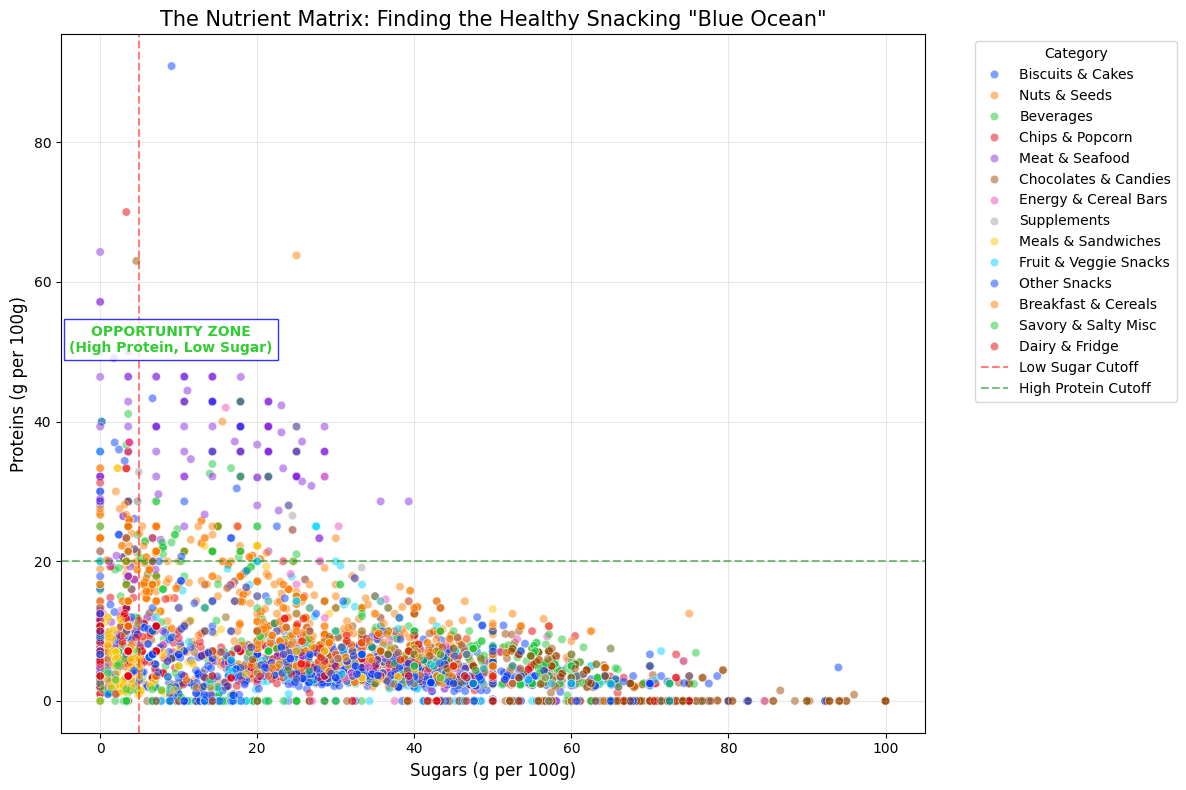

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# get rid of outliers for better visualization 
plot_df = df[
    (df['sugars_100g'] >= 0) & 
    (df['sugars_100g'] <= 100) & 
    (df['proteins_100g'] >= 0) & 
    (df['proteins_100g'] <= 100)
].copy()

# defination of quadrants
HIGH_PROTEIN_THRESHOLD = 20  # in grams
LOW_SUGAR_THRESHOLD = 5      # in grams

# 3. Create the Plot
plt.figure(figsize=(12, 8))

# Main Scatter plot
sns.scatterplot(
    data=plot_df,
    x='sugars_100g',
    y='proteins_100g',
    hue='high_level_category',  
    alpha=0.5,                  # transparency
    palette='bright'           
)

# draw the Quadrant Lines
plt.axvline(x=LOW_SUGAR_THRESHOLD, color='red', linestyle='--', alpha=0.5, label='Low Sugar Cutoff')
plt.axhline(y=HIGH_PROTEIN_THRESHOLD, color='green', linestyle='--', alpha=0.5, label='High Protein Cutoff')

# highlight the The Opportunity Zone
# Top-Left Quadrant: Low Sugar (< 5g) AND High Protein (> 20g)
plt.text(
    x=LOW_SUGAR_THRESHOLD+8 / 2, 
    y=HIGH_PROTEIN_THRESHOLD + 30, 
    s="OPPORTUNITY ZONE\n(High Protein, Low Sugar)", 
    color='limegreen', 
    weight='bold', 
    ha='center',
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='blue')
)

# 6. Formatting
plt.title('The Nutrient Matrix: Finding the Healthy Snacking "Blue Ocean"', fontsize=15)
plt.xlabel('Sugars (g per 100g)', fontsize=12)
plt.ylabel('Proteins (g per 100g)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Category")
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

In [11]:
# Get the counts of each category in the Opportunity Zone
top_left_quandrant = plot_df[
    (plot_df['sugars_100g'] < 5) & 
    (plot_df['proteins_100g'] > 20)
]
top_right_quandrant = plot_df[
    (plot_df['sugars_100g'] >= 5) &
    (plot_df['proteins_100g'] > 20)
]
bottom_left_quandrant = plot_df[
    (plot_df['sugars_100g'] < 5) &
    (plot_df['proteins_100g'] <= 20)
]
bottom_right_quandrant = plot_df[
    (plot_df['sugars_100g'] >= 5) &
    (plot_df['proteins_100g'] <= 20)
]
print("Top-Left Quadrant (Opportunity Zone) Total Count:", len(top_left_quandrant))
print("Top-Right Quadrant Total Count:", len(top_right_quandrant))
print("Bottom-Left Quadrant Total Count:", len(bottom_left_quandrant))
print("Bottom-Right Quadrant Total Count:", len(bottom_right_quandrant))

Top-Left Quadrant (Opportunity Zone) Total Count: 214
Top-Right Quadrant Total Count: 284
Bottom-Left Quadrant Total Count: 1491
Bottom-Right Quadrant Total Count: 4814


In [12]:
# create a "safe sugar" column to avoid dividing by zero (0 -> 0.1)
df['safe_sugar'] = df['sugars_100g'].replace(0, 0.1)

# calculate the ratio
df['protein_sugar_ratio'] = df['proteins_100g'] / df['safe_sugar']

df.head()

,creator,product_name,categories_en,countries_en,ingredients_text,additives_n,nutriscore_score,nutriscore_grade,nova_group,pnns_groups_1,...,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition-score-fr_100g,high_level_category,safe_sugar,protein_sugar_ratio
0,openfoodfacts-contributors,Madeleines ChocoLait,"snacks,sweet snacks,biscuits and cakes,cakes,c...",France,"Farine de blÃ© 27%, chocolat au lait 18% (sucr...",6.0,20.0,e,4.0,Sugary snacks,...,31.00,1.4,6.4,0.48,0.192,16.250000,20.0,Biscuits & Cakes,31.00,0.206452
1,openfoodfacts-contributors,Farandole de madeleine,"snacks,sweet snacks,biscuits and cakes,cakes,c...",Brazil,Madeleines ChocoNoir - Madeleines nappÃ©es de ...,6.0,9.0,c,4.0,Sugary snacks,...,1.85,18.5,37.0,0.88,0.352,1.750000,9.0,Biscuits & Cakes,1.85,20.000000
2,openfoodfacts-contributors,Multi Patents Collagen Peptides,"snacks,sweet snacks,biscuits and cakes,cakes,m...",France,"Multi Collagen Complex, Hydrolyzed Bovine Coll...",0.0,-1.0,a,3.0,Sugary snacks,...,9.09,0.0,90.9,0.00,0.000,0.251116,-1.0,Biscuits & Cakes,9.09,10.000000
3,openfoodfacts-contributors,Peanut Brittle,"snacks,sweet snacks,confectioneries",France,"Sugar, glucose syrup, peanuts (30%)",0.0,22.0,e,4.0,Sugary snacks,...,51.50,1.9,7.7,0.00,0.000,30.000000,22.0,Nuts & Seeds,51.50,0.149515
4,openfoodfacts-contributors,madeleine Bijou ChocoPÃ©pites,"snacks,sweet snacks,biscuits and cakes,cakes,m...",France,"Farine de _blÃ©_, pÃ©pites de chocolat 18% (su...",8.0,21.0,e,4.0,Sugary snacks,...,32.00,2.5,5.8,0.63,0.252,9.000000,21.0,Biscuits & Cakes,32.00,0.181250


In [ ]:
df.to_csv("dataset/snacks.csv", index=False)

### Task 4
Recommendation of the minimum protein and maximum sugar per 100g to be used to break into the market


In [14]:
mask_meat_sea =df["high_level_category"] == "Meat & Seafood"

meat_protein_mean =df[mask_meat_sea]["proteins_100g"].mean()
meat_sugar_mean = df[mask_meat_sea]["sugars_100g"].mean()

print(f"Average Protein in Meat & Seafood Snacks: {meat_protein_mean:.2f} g/100g")
print(f"Average Sugar in Meat & Seafood Snacks: {meat_sugar_mean:.2f} g/100g")

Average Protein in Meat & Seafood Snacks: 20.96 g/100g
Average Sugar in Meat & Seafood Snacks: 16.00 g/100g


#### The Recommendation
> **Based on the data, the biggest market opportunity is in Meat & Seafood, specifically targeting products with more than 37g of protein and less than 1.6g of sugar.**

In [15]:
# Craete the "Opportunity Zone" for Meat & Seafood
# Getting the products that are already hitting the high-performance targets.

opportunity_zone = df[
    (df["high_level_category"] == "Meat & Seafood") & 
    (df["proteins_100g"] > 20) & 
    (df["sugars_100g"] < 5)
]

# get the average specs of these of the protein and sugar
avg_protein = opportunity_zone["proteins_100g"].mean()
avg_sugar = opportunity_zone["sugars_100g"].mean()

# print the Insight
print(f"CATEGORY: Meat & Seafood")
print(f"TARGET PROTEIN: {avg_protein:.1f}g")
print(f"TARGET SUGAR: {avg_sugar:.1f}g")
print("-" * 30)
print(f"RECOMMENDATION TEXT:")
print(f"Based on the data, the biggest market opportunity is in Meat & Seafood, specifically targeting products with more than {avg_protein:.0f}g of protein and less than {avg_sugar:.1f}g of sugar.")

CATEGORY: Meat & Seafood
TARGET PROTEIN: 36.7g
TARGET SUGAR: 1.6g
------------------------------
RECOMMENDATION TEXT:
Based on the data, the biggest market opportunity is in Meat & Seafood, specifically targeting products with more than 37g of protein and less than 1.6g of sugar.


### Task 5

In [16]:
# get list of opportunity zone ingredients
ingredients_list = opportunity_zone["ingredients_text"].to_list()

# define protein keywords 
protein_map = {
    'beef': 'Beef',
    'pork': 'Pork',
    'bacon': 'Pork',
    'salami': 'Pork',
    'turkey': 'Turkey',
    'chicken': 'Chicken',
    'soy': 'Soy',
    'egg': 'Eggs',
    'cheese': 'Cheese',
    'milk': 'Cheese/Dairy',
    'whey': 'Cheese/Dairy',
    'morue': 'Fish'
}


found_ingredients = []

for text in ingredients_list:
    text = text.lower()
    #removes contents in brackets
    clean_text = re.sub(r'\([^)]*\)', '', text)
    
    # get unique sources in this product
    product_sources = set()
    for keyword, category in protein_map.items():
        if keyword in clean_text:
            product_sources.add(category)
    
    found_ingredients.extend(list(product_sources))

# count and print
counts = Counter(found_ingredients).most_common(3)

print("--- STORY 5 RESULT ---")
print("Top 3 Protein Drivers found in the text:")
for i, (source, count) in enumerate(counts, 1):
    print(f"{i}. {source} (Found in {count} products)")

--- STORY 5 RESULT ---
Top 3 Protein Drivers found in the text:
1. Beef (Found in 19 products)
2. Soy (Found in 13 products)
3. Pork (Found in 12 products)


### Task 6
I created a new metric called **`ingredient_count`** to measure how processed each category is.

**Key Insight:**
> **"Meat & Seafood" products are significantly 'cleaner' than the competition, with median ~12 ingredients per package, compared to Energy Bars which median ~25 ingredients.**

**Why this matters:**
Modern health consumers are moving away from "Ultra-Processed Foods" (UPFs). By recommending a Meat/Seafood snack, we are not just selling "High Protein"; we are selling "Simple, Real Food"—a powerful marketing narrative that Energy Bar competitors cannot claim.

In [17]:
def count_ingredients(text):
    if pd.isna(text) or text == "":
        return 0
    # split by comma to get a rough count
    return len(str(text).split(','))

# apply to the main df
df['ingredient_count'] = df['ingredients_text'].apply(count_ingredients)

# create the visualization 
fig = px.box(
    df, 
    x="high_level_category", 
    y="ingredient_count", 
    color="high_level_category",
    title="Complexity Analysis: Number of Ingredients per Category",
    labels={"ingredient_count": "Number of Ingredients (Lower is Cleaner)", "high_level_category": "Category"},
    height=500
)

fig.show()

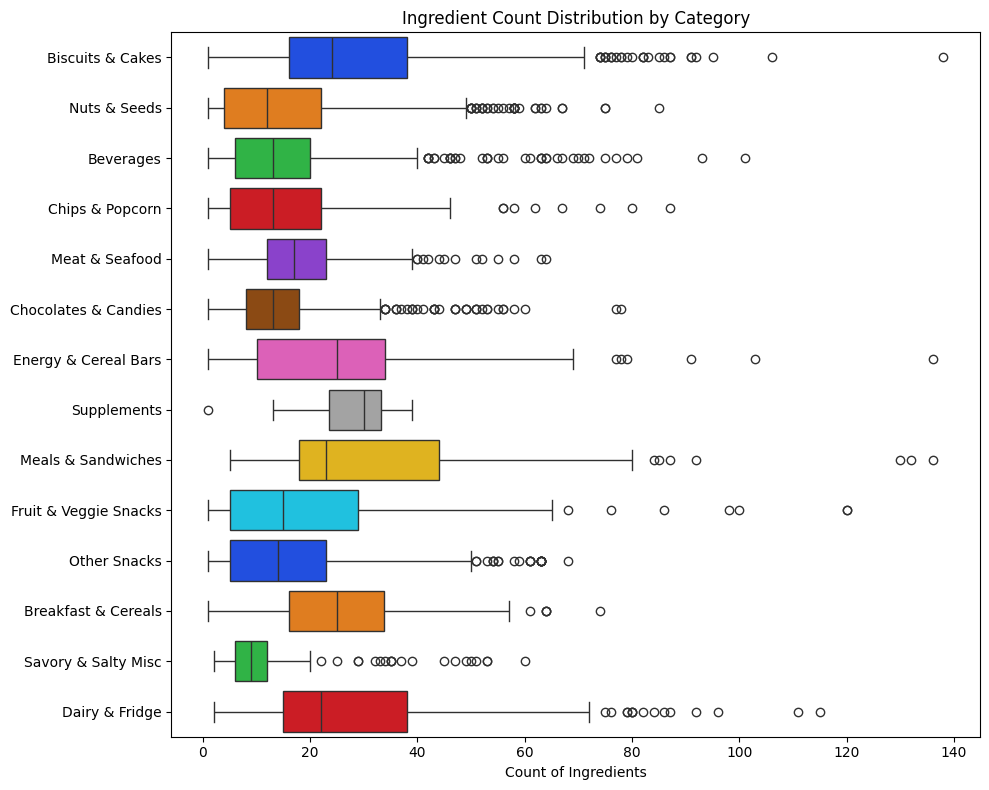

In [23]:
# This is mainly done to show the chart in the pdf for some reason plotly cannot be renedered on the pdf
plt.figure(figsize=(10, 8))

sns.boxplot(
    data=df,
    y="high_level_category",  
    x="ingredient_count",     
    palette="bright",
    hue="high_level_category", 
    legend=False               
)

plt.title("Ingredient Count Distribution by Category")
plt.xlabel("Count of Ingredients")
plt.ylabel("")  

plt.tight_layout()
plt.show();